# Imports

In [10]:
# Neural Network libraries
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim
import torch.nn.functional as F

import torchvision
import torchvision.transforms as transforms

# Other necessary libraries
import os
import sys
import math
import numpy as np
from numpy import asarray
import pandas as pd
import time
import pickle as pkl
import PIL.Image
from PIL import ImageGrab
from PIL import UnidentifiedImageError

# Plotting
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from matplotlib import font_manager
from matplotlib import image
from matplotlib import pyplot


# Progress
from tqdm import tqdm

# GUI
from tkinter import *
import tkinter.font as font
import imageio

# Data Preprocessing (COMPLETE)

The data used in this project was obtained at the publicly available Kaggle dataset at this link: https://www.kaggle.com/datasets/pascalbliem/handwritten-chinese-character-hanzi-datasets (zip size 13.2 GB)

## Folder Renaming (COMPLETE)

In [ ]:
%cd "data/"

# Gathering the latin-named directories
test_folders = [f.name for f in os.scandir('test') if f.is_dir()]
train_folders = [f.name for f in os.scandir('train') if f.is_dir()]

In [ ]:
%cd "./test"
i=0
for t in test_folders:
    i += 1
    try:
        os.rename(t, t.encode('cp437').decode('utf-8')) # convert to Mandarin Characters
    except UnicodeDecodeError:
        print(f'{i, t} causes UnicodeDecodeError')
    except UnicodeEncodeError:
        print(f'{i, t} causes UnicodeEncodeError')
        continue
i=0

%cd "../train"
for t in train_folders:
    i += 1
    try:
        os.rename(t, t.encode('cp437').decode('utf-8')) # convert to Mandarin Characters
    except UnicodeDecodeError:
        print(f'{i, t} causes UnicodeDecodeError')
    except UnicodeEncodeError:
        print(f'{i, t} causes UnicodeEncodeError')
        continue

In [ ]:
%cd "../"

## Image Preprocessing (COMPLETE)

image.dtype: float32
image.shape: (56, 56)


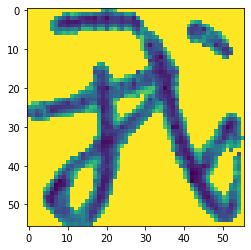

In [5]:
%matplotlib inline

# load image as pixel array
image = image.imread('data/test/我/1.png')

# summarize shape of the pixel array
print(f'image.dtype: {image.dtype}')
print(f'image.shape: {image.shape}')
#print(f'image.mode: {image.mode}')

# display the array of pixels as an image
pyplot.imshow(image)
pyplot.show()

In [16]:
def reshape_hanzi(img, width, height):
    return img.resize((64,64))

In [17]:
# for every single image in the data directory
#    reshape the image
#    print the path of any problematic images

for dirpath, dirnames, filenames in os.walk("."):
    for filename in [f for f in filenames if f.endswith(".png")]:
        filepath = os.path.join(dirpath, filename)
        try:
            img = PIL.Image.open(filepath)
            width, height = img.size

            new_image = reshape_hanzi(img, width, height)
            new_image.save(filepath)
        except (OSError, UnidentifiedImageError, NameError):
            print(filepath)

Images were 56x56 pixels **on average** before preprocessing. 

After preprocessing, all images were resized to 64x64 with interpolation, meaning some images were stretched.

## Preprocessing in PowerShell

Our dataset originally consisted of approximately 6,880,000 images: *(6,800 classes at 800 images)* 5,504,000 training images and *(6,880 classes at 200 images)* 1,376,000 testing images. However, it turned out that for a majority of the folders, half of the images were in the incorrect folder. Luckily for us, after sampling about fifty folders in the training data and then the same-labeled fifty folders in the testing data,  all of the incorrectly images followed the same naming pattern, i.e. ```*_*.png``` in which the asterisk was any digit -- images that did belong in the folder following the naming pattern of ```*.png```. After filtering for proper file names, we had about *(190 classes at 140 images)* 26,600 testing images and *(190 classes at 600 images)* 114,000 training images. 

Using Microsoft PowerShell, it was easy to mass-delete invalid images with the following commands:

```powershell
Get-Childitem -path C:\Users\aKost\Desktop\character_recognition\data\train 
-Filter *.png -Recurse | where-object {$_.Name -ilike "*_*"} | Remove-Item -Force
```

```powershell
Get-Childitem -path C:\Users\aKost\Desktop\character_recognition\data\test 
-Filter *.png -Recurse | where-object {$_.Name -ilike "*_*"} | Remove-Item -Force
```

The next roadblock we faced was computational power. Whether we used Google Colab or Aleksa's computer with an Nvidia Geforce RTX GPU, training was too slow or wildly inaccurate, or both. To just train the feed-forward neural network on all of the data would take approximately seventy-two hours for two hundred epochs, and would yield an average accuracy of less than one percent (< 1%) across the last fifty epochs.

We initially tried subsampling the data by using every other or every third image in a folder, but the speed improvement wasn't significant nor did training accuracy change at all. So, rather than training classifiers on the 6,880 characters provided, we decided to just filter for the 190 most common characters figuring that the models could eventually be scaled up. The purpose of cutting down to comparatively this few classes, but still maintaining a generally large number of classes is that we want to create a model that can handle the complexity and diversity of Chinese characters and learn to recognize characters based on features such as Chinese's 200+ common radicals, also known as Kangxi radicals.

The following PowerShell commands assisted in mass-deleting any data that did not fall within the 190 most common Chinese characters:

```powershell
Get-Childitem -path C:\Users\aKost\Desktop\character_recognition\data\train 
-Directory -Recurse| where-object -FilterScript { $_.Name -notin 
("的","一","是","了","我","不","人","在","他","有","这","个","上",
"们","来","到","时","大","地","为","子","中","你","说","生","国",
"年","着","就","那","会","家","可","下","而","过","天","去","能",
"对","小","多","然","于","心","学","么","之","都","好","看","起",
"发","当","没","成","只","如","事","把","还","用","第","样","道",
"想","作","种","开","美","总","从","无","情","己","面","最","女",
"但","现","前","些","所","同","日","手","又","行","意","动","方",
"期","它","头","经","长","儿","回","位","分","爱","老","因","很",
"给","名","法","间","斯","知","世","什","两","次","使","身","者",
"被","高","已","亲","其","进","此","话","常","与","活","正","感",
"见","明","问","力","理","尔","点","文","几","定","本","公","特",
"做","外","孩","相","西","果","走","将","月","十","实","向","声",
"车","全","信","重","三","机","工","物","气","每","并","别","真",
"打","太","新","比","才","便","夫","再","书","部","水","像","眼",
"等","体","却","加","电","主","界","门","利","海","受","听","表",
"德","少","克","代","员","许","先","口","由","死","安","写","性",
"马","光") } | Remove-Item -Recurse -Force
```

```powershell
Get-Childitem -path C:\Users\aKost\Desktop\character_recognition\data\test 
-Directory -Recurse| where-object -FilterScript { $_.Name -notin 
("的","一","是","了","我","不","人","在","他","有","这","个","上",
"们","来","到","时","大","地","为","子","中","你","说","生","国",
"年","着","就","那","会","家","可","下","而","过","天","去","能",
"对","小","多","然","于","心","学","么","之","都","好","看","起",
"发","当","没","成","只","如","事","把","还","用","第","样","道",
"想","作","种","开","美","总","从","无","情","己","面","最","女",
"但","现","前","些","所","同","日","手","又","行","意","动","方",
"期","它","头","经","长","儿","回","位","分","爱","老","因","很",
"给","名","法","间","斯","知","世","什","两","次","使","身","者",
"被","高","已","亲","其","进","此","话","常","与","活","正","感",
"见","明","问","力","理","尔","点","文","几","定","本","公","特",
"做","外","孩","相","西","果","走","将","月","十","实","向","声",
"车","全","信","重","三","机","工","物","气","每","并","别","真",
"打","太","新","比","才","便","夫","再","书","部","水","像","眼",
"等","体","却","加","电","主","界","门","利","海","受","听","表",
"德","少","克","代","员","许","先","口","由","死","安","写","性",
"马","光") } | Remove-Item -Recurse -Force
```

# FFNN *(Feed Forward Neural Network)*

- **IF USING DIRECTORY ```./DATA/SUB_TEST``` AND ```./DATA/SUB_TRAIN```**: 
    - the number of classes **must** be 25

- **IF USING DIRECTORY ```./DATA/TEST``` AND ```./DATA/TRAIN```**: 
    - the number of classes **must** be 190

## Hyperparameters and Data Loading

In [47]:
batch_size = 64 # multiples of 2 work best, but between 64 and 256
input_size=2500 # for the image size of 50x50
hidden_size=4096 # arbitrary, 2^12
num_classes=25 # using sub_train in the data loading part for FFNN
learning_rate=5e-4 # arbitrary, usually 0.001 --> 1e-3
epochs=50

In [48]:
# DATA
train_data = torchvision.datasets.ImageFolder(
    root = './data/sub_train/', # the FFNN was way too slow with even just 190 classes, so we use sub_{test/train}
    transform=transforms.Compose([ # Compose allows for multiple transformations, similar to Sequential
        transforms.Grayscale(num_output_channels=1), # for some reason the original channels was 3...
        transforms.Resize((50,50)), # make ALL images 50x50 (average images size was 54x54), method: interpolation
        transforms.ToTensor()]) # must send to tensor for the nn
)

test_data = torchvision.datasets.ImageFolder(
    root='./data/sub_test/',
    transform=transforms.Compose([
        transforms.Grayscale(num_output_channels=1),
        transforms.Resize((50,50)),
        transforms.ToTensor()])
)

# Display our class labels
print(train_data.class_to_idx)
print(test_data.class_to_idx)

{'一': 0, '三': 1, '上': 2, '下': 3, '不': 4, '与': 5, '世': 6, '两': 7, '个': 8, '中': 9, '为': 10, '主': 11, '么': 12, '之': 13, '书': 14, '了': 15, '事': 16, '于': 17, '些': 18, '亲': 19, '人': 20, '什': 21, '他': 22, '代': 23, '们': 24}
{'一': 0, '三': 1, '上': 2, '下': 3, '不': 4, '与': 5, '世': 6, '两': 7, '个': 8, '中': 9, '为': 10, '主': 11, '么': 12, '之': 13, '书': 14, '了': 15, '事': 16, '于': 17, '些': 18, '亲': 19, '人': 20, '什': 21, '他': 22, '代': 23, '们': 24}


In [49]:
train_loader = torch.utils.data.DataLoader(
    train_data,
    batch_size=batch_size,
    shuffle=True # this part is ABSOLUTELY NECESSARY, otherwise network accuracy stays at < 1% even after 200 epochs
)

test_loader = torch.utils.data.DataLoader(
    test_data,
    batch_size=batch_size,
    shuffle=True
)

torch.Size([64, 1, 50, 50])


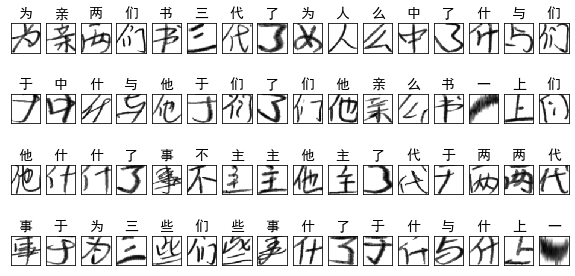

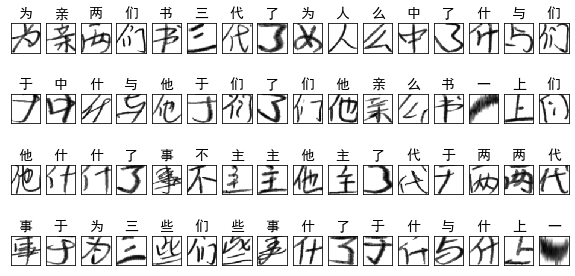

In [50]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

print(example_data.shape)

fig = plt.figure(figsize=(10,5))

# This is required to get the Chinese character to show in the plt plot
fontP = font_manager.FontProperties()
fontP.set_family('SimHei')
fontP.set_size(14)

# For each image in the batch
for i in range(64):
    # make a subplot
    plt.subplot(4,16,i+1)
    # display the image
    plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
    k = next(key for key, value in dict(test_data.class_to_idx).items() if value == example_targets[i])
    # set title as the proper Chinese character
    plt.title("{}".format(k),fontproperties=fontP)
    plt.xticks([])
    plt.yticks([])
fig

## Feed-Forward Neural Network Model Definition

In [51]:
class FFN(nn.Module):
    def __init__(self, 
        input_size=input_size, 
        hidden_size=hidden_size, 
        num_classes=num_classes, 
        learning_rate=learning_rate, 
        epochs=epochs
    ):
        super(FFN, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_classes = num_classes
        self.learning_rate = learning_rate
        self.epochs = epochs

        self.forward_pass = nn.Sequential(
            nn.Linear(input_size, 1024),
            nn.Linear(1024,1024),
            nn.Linear(1024,1024),
            nn.Linear(1024,1024),
            nn.Linear(1024,1024),
            nn.Linear(1024,1024),
            nn.Linear(1024,1024),
            nn.Linear(1024,1024),
            nn.Dropout(0.5),
            nn.Linear(1024, num_classes)
        )

    def forward(self, x):
        out = self.forward_pass(x)
        return out

In [52]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"=================DEVICE=================:\t{device}")

hanzi_ff = FFN().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(hanzi_ff.parameters(), lr=learning_rate) 

=================DEVICE=================:	cuda


## Training and Testing

In [53]:
epoch_list = [e+1 for e in range(epochs)]
loss_value = []
epoch_accuracy = []

for epoch in range(epochs):
    this_loss = np.array([])
    with tqdm(train_loader, unit="batch") as tepoch:
        for i, (images, classes) in enumerate(tepoch):
            tepoch.set_description(f"Epoch {epoch + 1}/{epochs}")
            images = images.reshape(-1, 2500).to(device)
            classes = classes.to(device)

            y_hat = hanzi_ff(images)

            loss = criterion(y_hat, classes)
            optimizer.zero_grad()
            
            this_loss = np.append(this_loss, [loss.item()])
            
            loss.backward()
            optimizer.step()
    
    loss_value.append(loss.item()) 
    if (epoch+1)%10 == 0:
        torch.save(hanzi_ff.state_dict(), f'./hanziff/models/hff_e{epoch+1}.pth')
    
    with torch.no_grad():
        correct = 0
        total = 0

        for images, classes in test_loader:
            images = images.reshape(-1, 2500).to(device)
            #print(classes)
            classes = classes.to(device)
            y_hat = hanzi_ff(images)

            _, predicted = torch.max(y_hat.data, 1)
            total += classes.size(0)
            correct += (predicted == classes).sum().item() 
        
        acc = correct / total
        print(f'Accuracy of the network: {(100.0 * acc):.2f} %;\tLoss: {(np.mean(this_loss)):.2f}')
        epoch_accuracy.append(acc)

LA_dict = {
    'epoch_list': epoch_list,
    'loss_value': loss_value,
    'epoch_accuracy': epoch_accuracy
}

with open('./hanziff/data/loss_accuracy.pickle','wb') as LA:
    LA = pkl.dump(LA_dict, LA)

Epoch 1/50: 100%|██████████| 234/234 [00:06<00:00, 36.32batch/s]


Accuracy of the network: 37.90 %;	Loss: 2.59


Epoch 2/50: 100%|██████████| 234/234 [00:06<00:00, 35.30batch/s]


Accuracy of the network: 40.58 %;	Loss: 1.90


Epoch 3/50: 100%|██████████| 234/234 [00:06<00:00, 34.11batch/s]


Accuracy of the network: 47.48 %;	Loss: 1.69


Epoch 4/50: 100%|██████████| 234/234 [00:06<00:00, 35.24batch/s]


Accuracy of the network: 40.58 %;	Loss: 1.57


Epoch 5/50: 100%|██████████| 234/234 [00:06<00:00, 34.93batch/s]


Accuracy of the network: 45.08 %;	Loss: 1.53


Epoch 6/50: 100%|██████████| 234/234 [00:06<00:00, 34.82batch/s]


Accuracy of the network: 44.35 %;	Loss: 1.47


Epoch 7/50: 100%|██████████| 234/234 [00:06<00:00, 34.54batch/s]


Accuracy of the network: 55.11 %;	Loss: 1.37


Epoch 8/50: 100%|██████████| 234/234 [00:06<00:00, 35.47batch/s]


Accuracy of the network: 47.88 %;	Loss: 1.32


Epoch 9/50: 100%|██████████| 234/234 [00:06<00:00, 35.36batch/s]


Accuracy of the network: 51.45 %;	Loss: 1.35


Epoch 10/50: 100%|██████████| 234/234 [00:07<00:00, 32.08batch/s]


Accuracy of the network: 55.48 %;	Loss: 1.25


Epoch 11/50: 100%|██████████| 234/234 [00:06<00:00, 33.65batch/s]


Accuracy of the network: 55.03 %;	Loss: 1.21


Epoch 12/50: 100%|██████████| 234/234 [00:06<00:00, 34.23batch/s]


Accuracy of the network: 52.21 %;	Loss: 1.19


Epoch 13/50: 100%|██████████| 234/234 [00:06<00:00, 33.99batch/s]


Accuracy of the network: 60.79 %;	Loss: 1.17


Epoch 14/50: 100%|██████████| 234/234 [00:06<00:00, 33.87batch/s]


Accuracy of the network: 59.06 %;	Loss: 1.18


Epoch 15/50: 100%|██████████| 234/234 [00:06<00:00, 33.85batch/s]


Accuracy of the network: 51.45 %;	Loss: 1.15


Epoch 16/50: 100%|██████████| 234/234 [00:06<00:00, 33.79batch/s]


Accuracy of the network: 52.21 %;	Loss: 1.14


Epoch 17/50: 100%|██████████| 234/234 [00:06<00:00, 34.26batch/s]


Accuracy of the network: 54.75 %;	Loss: 1.10


Epoch 18/50: 100%|██████████| 234/234 [00:06<00:00, 34.30batch/s]


Accuracy of the network: 57.43 %;	Loss: 1.12


Epoch 19/50: 100%|██████████| 234/234 [00:06<00:00, 33.91batch/s]


Accuracy of the network: 54.58 %;	Loss: 1.13


Epoch 20/50: 100%|██████████| 234/234 [00:06<00:00, 34.38batch/s]


Accuracy of the network: 56.71 %;	Loss: 1.10


Epoch 21/50: 100%|██████████| 234/234 [00:07<00:00, 33.08batch/s]


Accuracy of the network: 59.59 %;	Loss: 1.07


Epoch 22/50: 100%|██████████| 234/234 [00:07<00:00, 30.15batch/s]


Accuracy of the network: 59.70 %;	Loss: 1.04


Epoch 23/50: 100%|██████████| 234/234 [00:07<00:00, 30.71batch/s]


Accuracy of the network: 60.48 %;	Loss: 1.05


Epoch 24/50: 100%|██████████| 234/234 [00:07<00:00, 33.38batch/s]


Accuracy of the network: 55.81 %;	Loss: 1.12


Epoch 25/50: 100%|██████████| 234/234 [00:07<00:00, 33.35batch/s]


Accuracy of the network: 51.59 %;	Loss: 1.16


Epoch 26/50: 100%|██████████| 234/234 [00:06<00:00, 34.66batch/s]


Accuracy of the network: 57.41 %;	Loss: 1.03


Epoch 27/50: 100%|██████████| 234/234 [00:07<00:00, 32.47batch/s]


Accuracy of the network: 58.83 %;	Loss: 1.01


Epoch 28/50: 100%|██████████| 234/234 [00:06<00:00, 34.40batch/s]


Accuracy of the network: 56.76 %;	Loss: 1.00


Epoch 29/50: 100%|██████████| 234/234 [00:06<00:00, 34.56batch/s]


Accuracy of the network: 60.56 %;	Loss: 1.00


Epoch 30/50: 100%|██████████| 234/234 [00:06<00:00, 34.60batch/s]


Accuracy of the network: 58.24 %;	Loss: 0.99


Epoch 31/50: 100%|██████████| 234/234 [00:06<00:00, 35.05batch/s]


Accuracy of the network: 61.40 %;	Loss: 1.02


Epoch 32/50: 100%|██████████| 234/234 [00:06<00:00, 34.51batch/s]


Accuracy of the network: 61.07 %;	Loss: 0.99


Epoch 33/50: 100%|██████████| 234/234 [00:07<00:00, 33.29batch/s]


Accuracy of the network: 58.13 %;	Loss: 0.99


Epoch 34/50: 100%|██████████| 234/234 [00:06<00:00, 33.77batch/s]


Accuracy of the network: 58.44 %;	Loss: 1.03


Epoch 35/50: 100%|██████████| 234/234 [00:06<00:00, 33.93batch/s]


Accuracy of the network: 61.49 %;	Loss: 0.98


Epoch 36/50: 100%|██████████| 234/234 [00:06<00:00, 35.40batch/s]


Accuracy of the network: 60.90 %;	Loss: 0.95


Epoch 37/50: 100%|██████████| 234/234 [00:06<00:00, 34.49batch/s]


Accuracy of the network: 55.95 %;	Loss: 0.98


Epoch 38/50: 100%|██████████| 234/234 [00:06<00:00, 34.01batch/s]


Accuracy of the network: 23.84 %;	Loss: 4114.76


Epoch 39/50: 100%|██████████| 234/234 [00:06<00:00, 35.03batch/s]


Accuracy of the network: 35.55 %;	Loss: 5.08


Epoch 40/50: 100%|██████████| 234/234 [00:06<00:00, 34.62batch/s]


Accuracy of the network: 44.07 %;	Loss: 2.58


Epoch 41/50: 100%|██████████| 234/234 [00:06<00:00, 34.05batch/s]


Accuracy of the network: 45.42 %;	Loss: 2.00


Epoch 42/50: 100%|██████████| 234/234 [00:06<00:00, 35.22batch/s]


Accuracy of the network: 52.57 %;	Loss: 1.72


Epoch 43/50: 100%|██████████| 234/234 [00:06<00:00, 34.66batch/s]


Accuracy of the network: 52.26 %;	Loss: 1.66


Epoch 44/50: 100%|██████████| 234/234 [00:06<00:00, 34.90batch/s]


Accuracy of the network: 51.01 %;	Loss: 1.41


Epoch 45/50: 100%|██████████| 234/234 [00:06<00:00, 34.61batch/s]


Accuracy of the network: 53.27 %;	Loss: 1.37


Epoch 46/50: 100%|██████████| 234/234 [00:06<00:00, 35.08batch/s]


Accuracy of the network: 57.07 %;	Loss: 1.35


Epoch 47/50: 100%|██████████| 234/234 [00:06<00:00, 34.15batch/s]


Accuracy of the network: 53.61 %;	Loss: 1.30


Epoch 48/50: 100%|██████████| 234/234 [00:06<00:00, 34.61batch/s]


Accuracy of the network: 56.85 %;	Loss: 1.25


Epoch 49/50: 100%|██████████| 234/234 [00:06<00:00, 34.03batch/s]


Accuracy of the network: 59.39 %;	Loss: 1.20


Epoch 50/50: 100%|██████████| 234/234 [00:06<00:00, 33.83batch/s]


Accuracy of the network: 58.13 %;	Loss: 1.15


## Plotting

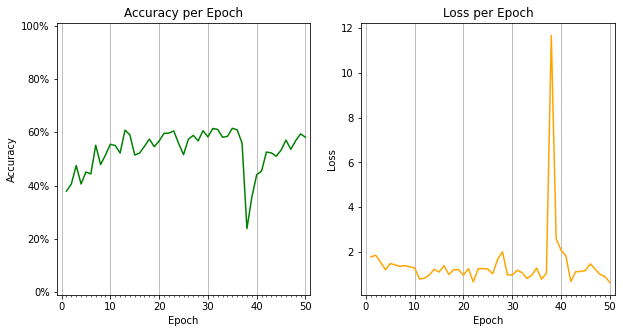

In [58]:
if os.path.exists('hanziff/data/loss_accuracy.pickle'):
    with open('hanziff/data/loss_accuracy.pickle','rb') as f:
        d = pkl.load(f)
    # Two figures: accuracy and loss
    fig, (ax2, ax1) = plt.subplots(1,2,figsize=(10,5))
    
    # Accuracy plotting
    ax2.plot(d['epoch_list'], np.array(d['epoch_accuracy'])*(100), 'green')
    ax2.set(xlabel='Epoch', ylabel='Accuracy',title="Accuracy per Epoch")
    ax2.set_xlim(-1, 50+1)
    ax2.set_ylim(-1,101)
    ax2.set_xticks([i+1 for i in range(50)], minor=True)
    # Getting percentage format on y-axis
    ax2.yaxis.set_major_formatter(mtick.PercentFormatter())
    
    # Loss for the FFNN was extremely high, so I scale it down here by 1e-4
    ax1.plot(d['epoch_list'], np.array(d['loss_value']), color='orange')
    ax1.set(xlabel='Epoch', ylabel='Loss',title="Loss per Epoch")
    ax1.set_xlim(-1,50 + 1)
    ax1.set_xticks([i+1 for i in range(50)], minor=True)
    
    ax1.grid(axis='x')
    ax2.grid(axis='x')
    plt.show();
    
else:
    fig, (ax2, ax1) = plt.subplots(1,2,figsize=(10,5))

    # Accuracy plotting 
    ax2.plot(epoch_list, np.array(epoch_accuracy)*100, 'green')
    ax2.set(xlabel='Epoch', ylabel='Accuracy',title="Accuracy per Epoch")
    ax2.set_xlim(-1, epochs+1)
    ax2.set_xticks([i+1 for i in range(epochs)], minor=True)
    # Getting percentage format
    ax2.yaxis.set_major_formatter(mtick.PercentFormatter())

    # Loss plotting
    ax1.plot(epoch_list, np.array(loss_value), color='orange')
    ax1.set(xlabel='Epoch', ylabel='Loss',title="Loss per Epoch")
    ax1.set_xlim(-1, epochs + 1)
    ax1.set_xticks([i+1 for i in range(epochs)], minor=True)

    ax1.grid(axis='x')
    ax2.grid(axis='x')
    plt.show();

# CNN *(Convolutional Neural Network)*

## Hyperparameters and Data Loading

In [11]:
batch_size = 64
num_classes = 190 # the preserved 190 most common Chinese characters as classes
learning_rate = 5e-4
epochs = 50

In early experimentation, it showed that the CNN worked faster and predicted more accurately than the feed-forward NN, and so we'll use the larger subset with 190 classes (characters).

In [3]:
train_data = torchvision.datasets.ImageFolder(
    root = './data/train/',
    transform=transforms.Compose([ # Compose allows us to perform multiple transforms, like Sequential does for NN layers
        transforms.Grayscale(num_output_channels=1), # our data, for some reason, has 3 channels, so we scale down to 1
        transforms.Resize((32,32)), # For the sake of computation, I resize here to 32x32
        transforms.ToTensor()]) # Cast data to tensor
)

test_data = torchvision.datasets.ImageFolder(
    root='./data/test/',
    transform=transforms.Compose([
        transforms.Grayscale(num_output_channels=1),
        transforms.Resize((32,32)),
        transforms.ToTensor()])
)


print(train_data.class_to_idx)

train_loader = torch.utils.data.DataLoader(
    train_data,
    batch_size=batch_size,
    shuffle=True # this part is ABSOLUTELY NECESSARY, otherwise network accuracy stays at < 1% even after 200 epochs
)

test_loader = torch.utils.data.DataLoader(
    test_data,
    batch_size=batch_size,
    shuffle=True
)

{'一': 0, '三': 1, '上': 2, '下': 3, '不': 4, '与': 5, '世': 6, '两': 7, '个': 8, '中': 9, '为': 10, '主': 11, '么': 12, '之': 13, '书': 14, '了': 15, '事': 16, '于': 17, '些': 18, '亲': 19, '人': 20, '什': 21, '他': 22, '代': 23, '们': 24, '但': 25, '位': 26, '体': 27, '作': 28, '你': 29, '使': 30, '便': 31, '信': 32, '做': 33, '像': 34, '儿': 35, '先': 36, '光': 37, '克': 38, '全': 39, '公': 40, '其': 41, '再': 42, '写': 43, '几': 44, '分': 45, '利': 46, '别': 47, '到': 48, '前': 49, '力': 50, '加': 51, '动': 52, '十': 53, '却': 54, '去': 55, '口': 56, '只': 57, '同': 58, '向': 59, '员': 60, '回': 61, '因': 62, '国': 63, '在': 64, '地': 65, '声': 66, '外': 67, '多': 68, '大': 69, '天': 70, '太': 71, '夫': 72, '头': 73, '女': 74, '好': 75, '如': 76, '子': 77, '学': 78, '孩': 79, '它': 80, '安': 81, '实': 82, '家': 83, '对': 84, '将': 85, '少': 86, '尔': 87, '就': 88, '工': 89, '己': 90, '已': 91, '年': 92, '并': 93, '开': 94, '德': 95, '性': 96, '总': 97, '情': 98, '想': 99, '感': 100, '成': 101, '我': 102, '所': 103, '手': 104, '才': 105, '打': 106, '把': 107, '文': 108, '斯': 109, '新': 110,

torch.Size([64, 1, 32, 32])


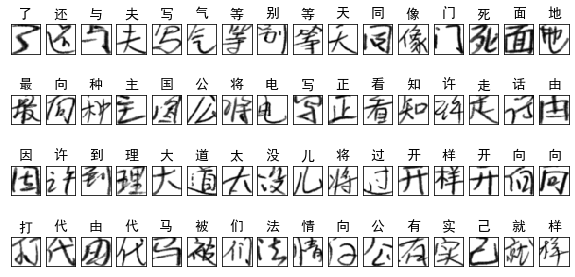

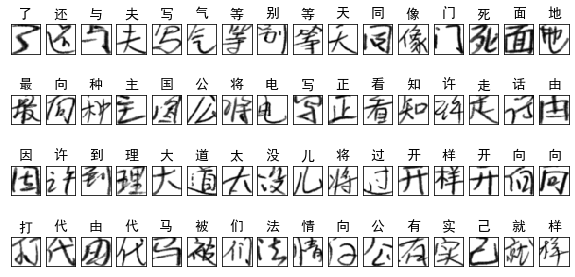

In [4]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

print(example_data.shape)

fig = plt.figure(figsize=(10,5))

# This is required to get the Chinese character to show in the plt plot
fontP = font_manager.FontProperties()
fontP.set_family('SimHei')
fontP.set_size(14)

# For each image in the batch
for i in range(64):
    # make a subplot
    plt.subplot(4,16,i+1)
    # display the image
    plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
    k = next(key for key, value in dict(test_data.class_to_idx).items() if value == example_targets[i])
    # set title as the proper Chinese character
    plt.title("{}".format(k),fontproperties=fontP)
    plt.xticks([])
    plt.yticks([])
fig

## Convolutional Neural Network Model Definition

In [12]:
class ConvNet(nn.Module):
    def __init__(self, input_channels=1, num_classes=num_classes):
        super(ConvNet, self).__init__()
        self.layer1 = nn.Sequential(
            # input(n=100,C=1,H=32,W=32)
            nn.Conv2d(
                in_channels=input_channels, 
                out_channels=16, 
                kernel_size=3, 
                stride=1, 
                padding=1
            ),
            # floor(((H + 2P - D(K-1) - 1) / S) + 1)
            # output(n=100, C=16, H=32, W=32)

            nn.BatchNorm2d(
                num_features=16
            ),

            nn.ReLU(),

            nn.MaxPool2d(
                kernel_size=2, stride=2
            )
            # floor(((H + 2P - D(K - 1) - 1) / S) + 1)
            #OUTPUT(100,16,16,16)

        )

        self.layer2 = nn.Sequential(
            #INPUT(100,16,16,16)
            nn.Conv2d(
                in_channels=16, 
                out_channels=32, 
                kernel_size=3, 
                stride=1, 
                padding=1
            ),
            # floor(((H + 2P - D(K-1) - 1) / S) + 1)
            #OUTPUT(100,32,16,16)

            nn.BatchNorm2d(
                num_features=32
            ),

            nn.ReLU(),

            nn.MaxPool2d(
                kernel_size=(2,2), stride=(2,2)
            )
            # floor(((H + 2P - D(K - 1) - 1) / S) + 1)
            #OUTPUT(100,32,8,8)
        )

        self.layer3 = nn.Sequential(
            #INPUT(100,32,8,8)
            nn.Conv2d(
                in_channels=32, out_channels=64, kernel_size=(3,3), stride=(1,1), padding=(1,1)
            ),
            # floor(((H + 2P - D(K-1) - 1) / S) + 1)

            nn.BatchNorm2d(
                num_features=64
            ),

            nn.ReLU(),
            
            nn.MaxPool2d(
                kernel_size=(2,2), stride=(2,2)
            )
            # floor(((H + 2P - D(K - 1) - 1) / S) + 1)
            #OUTPUT(100,64,4,4)
        )
        
        self.layer4 = nn.Sequential(
            #INPUT(100,64,4,4)
            nn.Conv2d(
                in_channels=64, out_channels=128, kernel_size=(3,3), stride=(1,1), padding=(1,1)
            ),
            # floor(((H + 2P - D(K-1) - 1) / S) + 1)

            nn.BatchNorm2d(
                num_features=128
            ),

            nn.ReLU(),

            nn.MaxPool2d(
                kernel_size=(2,2), stride=(2,2)
            )
            # floor(((H + 2P - D(K - 1) - 1) / S) + 1)
            #OUTPUT(100,128,2,2)
        )
        self.layer5 = nn.Sequential(
            #INPUT(100,128,2,2)
            nn.Conv2d(
                in_channels=128, out_channels=256, kernel_size=(3,3), stride=(1,1), padding=(1,1)
            ),
            # floor(((H + 2P - D(K-1) - 1) / S) + 1)

            nn.BatchNorm2d(
                num_features=256
            ),

            nn.ReLU(),

            nn.MaxPool2d(
                kernel_size=(2,2), stride=(2,2)
            )
            # floor(((H + 2P - D(K - 1) - 1) / S) + 1)
            #OUTPUT(100,128,1,1)
        )
        
        # flatten in forward()

        #INPUT(128,1,1)
        #self.fc = nn.Linear(
        #    in_features=128*1*1, out_features=num_classes
        #)
        self.ff_out = nn.Sequential(
            nn.Linear(in_features=256*1*1, out_features=128),
            nn.Dropout(0.4), # to prevent overfitting of the training data
            nn.Linear(128, num_classes)
        )
        
    def forward(self, x):
        # define the forward method based on your defined network architecture
        out1 = self.layer1(x)
        out2 = self.layer2(out1)
        out3 = self.layer3(out2)
        out4 = self.layer4(out3)
        out_ = self.layer5(out4)
        
        # flattening
        out5 = out_.reshape(out_.shape[0], -1)

        out = self.ff_out(out5)
        return out

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

hanzi_cnn = ConvNet().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(hanzi_cnn.parameters(), lr=learning_rate)

## Training and Testing

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"=================DEVICE=================:\t{device}")

epoch_list = [e+1 for e in range(epochs)]
loss_value = []
epoch_accuracy = []

for epoch in range(epochs):
        
    this_loss = np.array([])
    
    with tqdm(train_loader, unit="batch") as tepoch:
        for i, (images, classes) in enumerate(tepoch):
            tepoch.set_description(f"Epoch {epoch + 1}/{epochs}")
            
            images = images.to(device)
            classes = classes.to(device)

            y_hat = hanzi_cnn(images)

            loss = criterion(y_hat, classes)
            optimizer.zero_grad()
            
            this_loss = np.append(this_loss, loss.item())

            loss.backward()
            optimizer.step()

    loss_value.append(loss.item()) 
    
    
    if (epoch+1)%2 == 0:
        torch.save(hanzi_cnn.state_dict(), f'./hanzicnn/models/hcnn_e{epoch+1}.pth')
        print("===SAVED===")
    with torch.no_grad():
        correct = 0
        total = 0

        for images, classes in test_loader:
            images = images.to(device)
            classes = classes.to(device)
            
            y_hat = hanzi_cnn(images)

            _, predicted = torch.max(y_hat.data, 1)
            total += classes.size(0)
            correct += (predicted == classes).sum().item() 
        
        acc = correct / total
        print(f'Accuracy of the network: {(100.0 * acc):.2f} %;\tLoss: {(np.mean(this_loss)):.2f}')
        epoch_accuracy.append(acc)
        
LA_dict = {
    'epoch_list': epoch_list,
    'loss_value': loss_value,
    'epoch_accuracy': epoch_accuracy
}

with open('./hanzicnn/data/loss_accuracy.pickle','wb') as LA:
    LA = pkl.dump(LA_dict, LA)

=================DEVICE=================:	cuda


Epoch 1/50: 100%|██████████| 1779/1779 [01:17<00:00, 22.99batch/s]


Accuracy of the network: 63.84 %;	Loss: 1.58


Epoch 2/50: 100%|██████████| 1779/1779 [00:53<00:00, 33.39batch/s]


===SAVED===
Accuracy of the network: 70.74 %;	Loss: 0.48


Epoch 3/50: 100%|██████████| 1779/1779 [00:53<00:00, 33.17batch/s]


Accuracy of the network: 76.62 %;	Loss: 0.35


Epoch 4/50: 100%|██████████| 1779/1779 [00:53<00:00, 32.97batch/s]


===SAVED===
Accuracy of the network: 76.30 %;	Loss: 0.29


Epoch 5/50: 100%|██████████| 1779/1779 [00:53<00:00, 33.12batch/s]


Accuracy of the network: 80.61 %;	Loss: 0.24


Epoch 6/50: 100%|██████████| 1779/1779 [00:53<00:00, 33.03batch/s]


===SAVED===
Accuracy of the network: 79.76 %;	Loss: 0.21


Epoch 7/50: 100%|██████████| 1779/1779 [00:53<00:00, 32.99batch/s]


Accuracy of the network: 81.50 %;	Loss: 0.19


Epoch 8/50: 100%|██████████| 1779/1779 [00:53<00:00, 33.13batch/s]


===SAVED===
Accuracy of the network: 79.41 %;	Loss: 0.17


Epoch 9/50: 100%|██████████| 1779/1779 [00:54<00:00, 32.67batch/s]


Accuracy of the network: 82.50 %;	Loss: 0.15


Epoch 10/50: 100%|██████████| 1779/1779 [00:54<00:00, 32.86batch/s]


===SAVED===
Accuracy of the network: 79.83 %;	Loss: 0.14


Epoch 11/50: 100%|██████████| 1779/1779 [00:53<00:00, 33.15batch/s]


Accuracy of the network: 79.53 %;	Loss: 0.12


Epoch 12/50: 100%|██████████| 1779/1779 [00:53<00:00, 33.23batch/s]


===SAVED===
Accuracy of the network: 84.19 %;	Loss: 0.11


Epoch 13/50: 100%|██████████| 1779/1779 [00:53<00:00, 33.20batch/s]


Accuracy of the network: 82.01 %;	Loss: 0.10


Epoch 14/50: 100%|██████████| 1779/1779 [00:53<00:00, 33.28batch/s]


===SAVED===
Accuracy of the network: 83.57 %;	Loss: 0.09


Epoch 15/50: 100%|██████████| 1779/1779 [00:53<00:00, 33.20batch/s]


Accuracy of the network: 81.21 %;	Loss: 0.09


Epoch 16/50: 100%|██████████| 1779/1779 [00:53<00:00, 33.15batch/s]


===SAVED===
Accuracy of the network: 83.72 %;	Loss: 0.08


Epoch 17/50: 100%|██████████| 1779/1779 [00:53<00:00, 33.06batch/s]


Accuracy of the network: 83.38 %;	Loss: 0.08


Epoch 18/50: 100%|██████████| 1779/1779 [00:55<00:00, 31.96batch/s]


===SAVED===
Accuracy of the network: 82.87 %;	Loss: 0.07


Epoch 19/50: 100%|██████████| 1779/1779 [00:55<00:00, 31.93batch/s]


Accuracy of the network: 84.02 %;	Loss: 0.07


Epoch 20/50: 100%|██████████| 1779/1779 [00:55<00:00, 31.95batch/s]


===SAVED===
Accuracy of the network: 83.08 %;	Loss: 0.07


Epoch 21/50: 100%|██████████| 1779/1779 [00:55<00:00, 32.10batch/s]


Accuracy of the network: 83.27 %;	Loss: 0.06


Epoch 22/50: 100%|██████████| 1779/1779 [00:54<00:00, 32.54batch/s]


===SAVED===
Accuracy of the network: 83.22 %;	Loss: 0.06


Epoch 23/50: 100%|██████████| 1779/1779 [00:53<00:00, 33.25batch/s]


Accuracy of the network: 84.42 %;	Loss: 0.06


Epoch 24/50: 100%|██████████| 1779/1779 [00:53<00:00, 33.06batch/s]


===SAVED===
Accuracy of the network: 84.09 %;	Loss: 0.06


Epoch 25/50: 100%|██████████| 1779/1779 [00:53<00:00, 33.02batch/s]


Accuracy of the network: 83.17 %;	Loss: 0.06


Epoch 26/50: 100%|██████████| 1779/1779 [00:55<00:00, 32.12batch/s]


===SAVED===
Accuracy of the network: 83.78 %;	Loss: 0.05


Epoch 27/50: 100%|██████████| 1779/1779 [00:56<00:00, 31.76batch/s]


Accuracy of the network: 84.08 %;	Loss: 0.05


Epoch 28/50: 100%|██████████| 1779/1779 [00:55<00:00, 31.90batch/s]


===SAVED===
Accuracy of the network: 84.52 %;	Loss: 0.05


Epoch 29/50: 100%|██████████| 1779/1779 [00:55<00:00, 31.96batch/s]


Accuracy of the network: 83.26 %;	Loss: 0.04


Epoch 30/50: 100%|██████████| 1779/1779 [00:55<00:00, 31.86batch/s]


===SAVED===
Accuracy of the network: 85.55 %;	Loss: 0.04


Epoch 31/50: 100%|██████████| 1779/1779 [00:55<00:00, 31.87batch/s]


Accuracy of the network: 82.96 %;	Loss: 0.04


Epoch 32/50: 100%|██████████| 1779/1779 [00:56<00:00, 31.51batch/s]


===SAVED===
Accuracy of the network: 83.55 %;	Loss: 0.04


Epoch 33/50: 100%|██████████| 1779/1779 [00:53<00:00, 33.09batch/s]


Accuracy of the network: 83.55 %;	Loss: 0.04


Epoch 34/50: 100%|██████████| 1779/1779 [00:54<00:00, 32.53batch/s]


===SAVED===
Accuracy of the network: 84.44 %;	Loss: 0.04


Epoch 35/50: 100%|██████████| 1779/1779 [00:57<00:00, 31.17batch/s]


Accuracy of the network: 84.64 %;	Loss: 0.04


Epoch 36/50: 100%|██████████| 1779/1779 [00:53<00:00, 33.27batch/s]


===SAVED===
Accuracy of the network: 84.49 %;	Loss: 0.04


Epoch 37/50: 100%|██████████| 1779/1779 [00:54<00:00, 32.90batch/s]


Accuracy of the network: 81.85 %;	Loss: 0.04


Epoch 38/50: 100%|██████████| 1779/1779 [00:53<00:00, 33.12batch/s]


===SAVED===
Accuracy of the network: 84.52 %;	Loss: 0.04


Epoch 39/50: 100%|██████████| 1779/1779 [00:53<00:00, 33.23batch/s]


Accuracy of the network: 86.56 %;	Loss: 0.03


Epoch 40/50: 100%|██████████| 1779/1779 [00:53<00:00, 33.09batch/s]


===SAVED===
Accuracy of the network: 84.55 %;	Loss: 0.03


Epoch 41/50: 100%|██████████| 1779/1779 [00:54<00:00, 32.61batch/s]


Accuracy of the network: 82.78 %;	Loss: 0.03


Epoch 42/50: 100%|██████████| 1779/1779 [00:55<00:00, 31.90batch/s]


===SAVED===
Accuracy of the network: 86.02 %;	Loss: 0.04


Epoch 43/50: 100%|██████████| 1779/1779 [00:55<00:00, 31.93batch/s]


Accuracy of the network: 84.98 %;	Loss: 0.03


Epoch 44/50: 100%|██████████| 1779/1779 [00:55<00:00, 32.17batch/s]


===SAVED===
Accuracy of the network: 84.21 %;	Loss: 0.03


Epoch 45/50: 100%|██████████| 1779/1779 [00:55<00:00, 31.92batch/s]


Accuracy of the network: 82.67 %;	Loss: 0.03


Epoch 46/50: 100%|██████████| 1779/1779 [00:53<00:00, 33.33batch/s]


===SAVED===
Accuracy of the network: 83.54 %;	Loss: 0.03


Epoch 47/50: 100%|██████████| 1779/1779 [00:53<00:00, 33.27batch/s]


Accuracy of the network: 84.52 %;	Loss: 0.03


Epoch 48/50: 100%|██████████| 1779/1779 [00:53<00:00, 33.17batch/s]


===SAVED===
Accuracy of the network: 84.35 %;	Loss: 0.03


Epoch 49/50: 100%|██████████| 1779/1779 [00:54<00:00, 32.45batch/s]


Accuracy of the network: 85.04 %;	Loss: 0.03


Epoch 50/50: 100%|██████████| 1779/1779 [00:56<00:00, 31.74batch/s]


===SAVED===
Accuracy of the network: 84.34 %;	Loss: 0.03


## Plotting

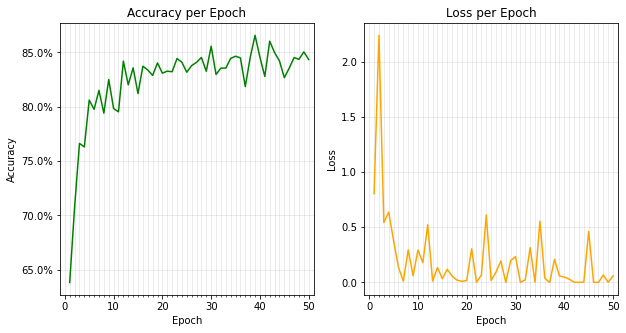

In [8]:
if os.path.exists('./hanzicnn/data/loss_accuracy.pickle'):
    with open('./hanzicnn/data/loss_accuracy.pickle','rb') as f:
        d = pkl.load(f)

    fig, (ax2, ax1) = plt.subplots(1,2,figsize=(10,5))

    ax1.plot(d['epoch_list'], np.array(d['loss_value']), color='orange')
    ax1.set(xlabel='Epoch', ylabel='Loss',title="Loss per Epoch")
    ax1.set_xlim(-1, 50 + 1)
    ax1.set_xticks([i+1 for i in range(50)], minor=True)
    

    ax2.plot(d['epoch_list'], np.array(d['epoch_accuracy'])*(100), 'green')
    ax2.set(xlabel='Epoch', ylabel='Accuracy',title="Accuracy per Epoch")
    ax2.set_xlim(-1, 50+1)
    ax2.set_xticks([i+1 for i in range(50)], minor=True)
    ax2.yaxis.set_major_formatter(mtick.PercentFormatter())

    
    ax2.grid(which='both', alpha=0.3)
    ax1.grid(which='both', alpha=0.3)

    plt.show();
else:
    fig, (ax2, ax1) = plt.subplots(1,2,figsize=(10,5))

    ax2.plot(epoch_list, np.array(epoch_accuracy)*100, 'green')
    ax2.set(xlabel='Epoch', ylabel='Accuracy',title="Accuracy per Epoch")
    ax2.set_xlim(-1, epochs+1)
    ax2.set_xticks([i+1 for i in range(epochs)], minor=True)
    ax2.yaxis.set_major_formatter(mtick.PercentFormatter())

    ax1.plot(epoch_list, loss_value, color='orange')
    ax1.set(xlabel='Epoch', ylabel='Loss',title="Loss per Epoch")
    ax1.set_xlim(-1, epochs + 1)
    ax1.set_xticks([i+1 for i in range(epochs)], minor=True)

    ax2.grid(which='both', alpha=0.3)
    ax1.grid(which='both', alpha=0.3)

    plt.show();

# GUI *(Graphical User Interface)*

## Loading the Model and Classes

We will be using the CNN model of the 22nd epoch as it had the highest accuracy **and** a minimum loss in its surrounding model losses (see most recent figures at end of CNN section immediately before GUI section). 

```torchtorch.nn```, ```torch.optim```, ```torch.nn.functional```, ```torchvision```, ```torchvision.transforms```, ```PIL.ImageGrab```, ```tkinter```, ```tkinter.font```, and ```imageio``` **must already be imported** as used by ConvNet, the **hyperparameters** before ConvNet must be defined, and the ConvNet class definition itself **must** be defined already.

In [13]:
model = ConvNet(input_channels=1, num_classes=190)
model.load_state_dict(torch.load('./hanzicnn/models/hcnn_e22.pth'), strict=False)
model.eval()

test_data = torchvision.datasets.ImageFolder(
    root='./data/test/',
    transform=transforms.Compose([
        transforms.Grayscale(num_output_channels=1),
        transforms.Resize((32,32)),
        transforms.ToTensor()])
)

class_idx = test_data.class_to_idx

def get_char(idx):
    return next(key for key, value in class_idx.items() if value == idx)

In [14]:
# project_gui.py
# // pip install Pillow
from turtle import pos, width
from PIL import Image, ImageDraw, ImageGrab 
import tkinter.font as font
import tkinter as tk

WHITE = (255, 255, 255)

class gui:
    def __init__(self, root):
        self.root = root
        self.width = 640 
        self.height = 480 # Dimension of canvas
        
        self.drawWidgets() # Setup widgets (canvas, buttons)
        
        self.image = Image.new("RGB", (self.width, self.height), WHITE)
        self.draw_image = ImageDraw.Draw(self.image)
        
        self.canvas.bind('<B1-Motion>', self.draw) # Setting button to draw on canvas. (Left click motion)
    
    def draw(self, event):
        # Canvas drawing
        x1, y1 = (event.x - 1), (event.y - 1) # Creating bounding box for oval to be drawing in GUI
        x2, y2 = (event.x + 1), (event.y + 1)

        self.canvas.create_oval(x1, y1, x2, y2, fill="black", width=7) # Draw for usesr
        self.draw_image.line([x1, y1, x2, y2], fill="black", width=10) # Draw in memory for image storing
        
   
    def clear(self):
        # Clear canvas
        self.canvas.delete(tk.ALL)
        self.image = Image.new("RGB", (self.width, self.height), WHITE)
        self.draw_image = ImageDraw.Draw(self.image)
        self.canvas.bind('<B1-Motion>', self.draw)

    def get_drawing(self):
        
        filename = 'image.png'
        
        self.image.resize((32,32))
        self.image.convert("L")
        self.image.save(filename)

        return self.image
        
    def recognize(self):
        # Classify canvas
        predictions = []
        percentage = []

        drawing = self.get_drawing()
        with torch.no_grad():
            
            convert = transforms.Compose([
                transforms.Grayscale(num_output_channels=1),
                transforms.Resize((32,32)),
                transforms.ToTensor()
            ])
            
            drawing = convert(drawing)
            
            drawing = drawing.unsqueeze(0)
            #print(drawing.shape)
            
            output = model(drawing)

            prob = F.softmax(output, dim=1)
            top_p, top_class = prob.topk(1, dim = 1)

            self.var.set(f"PREDICTED CHARACTER: {get_char(top_class.item())}\tLIKELIHOOD: {(top_p.item()):.4f}")
            self.label.config(text = self.var)
            
    def drawWidgets(self):
        # Drawing canvas
        self.canvas = tk.Canvas(self.root, width=self.width, height=self.height, bg='white')
        self.canvas.pack()

        # Buttons
        buttonFont = font.Font(family='Helvetica', size=10, weight='bold')

        self.classify_button = tk.Button(command=self.recognize, text='classify', fg='orange', font=buttonFont)
        self.clear_button = tk.Button(command=self.clear, text='clear', fg='black', font=buttonFont)
      
        # Button Positioning
        self.classify_button.pack(side=tk.LEFT)
        self.clear_button.pack(side=tk.RIGHT)
        
        self.var = StringVar()
        self.label = tk.Label(self.root, textvariable=self.var, relief=RAISED, font=(12))

        self.var.set("PREDICTED CHARACTER:\tLIKELIHOOD:")
        self.label.pack()



root = tk.Tk()

run = gui(root)
run.canvas.pack(expand=tk.YES, fill=tk.BOTH)

root.title('Handwritten Chinese Charater Recognizer')
root.mainloop()

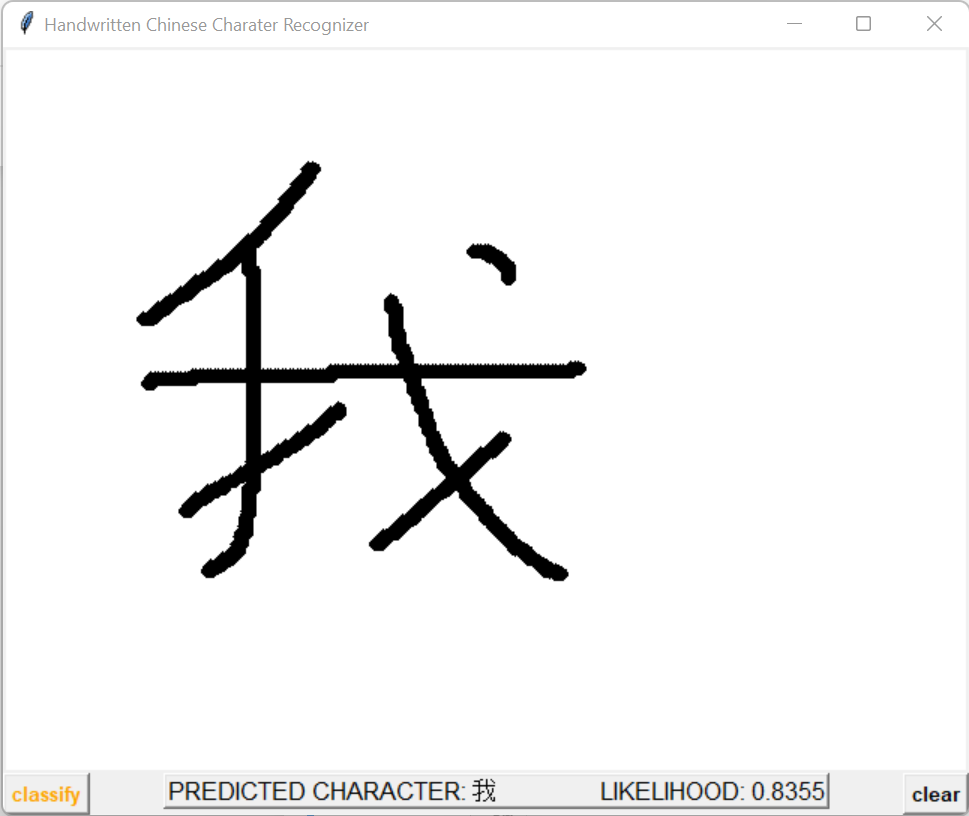

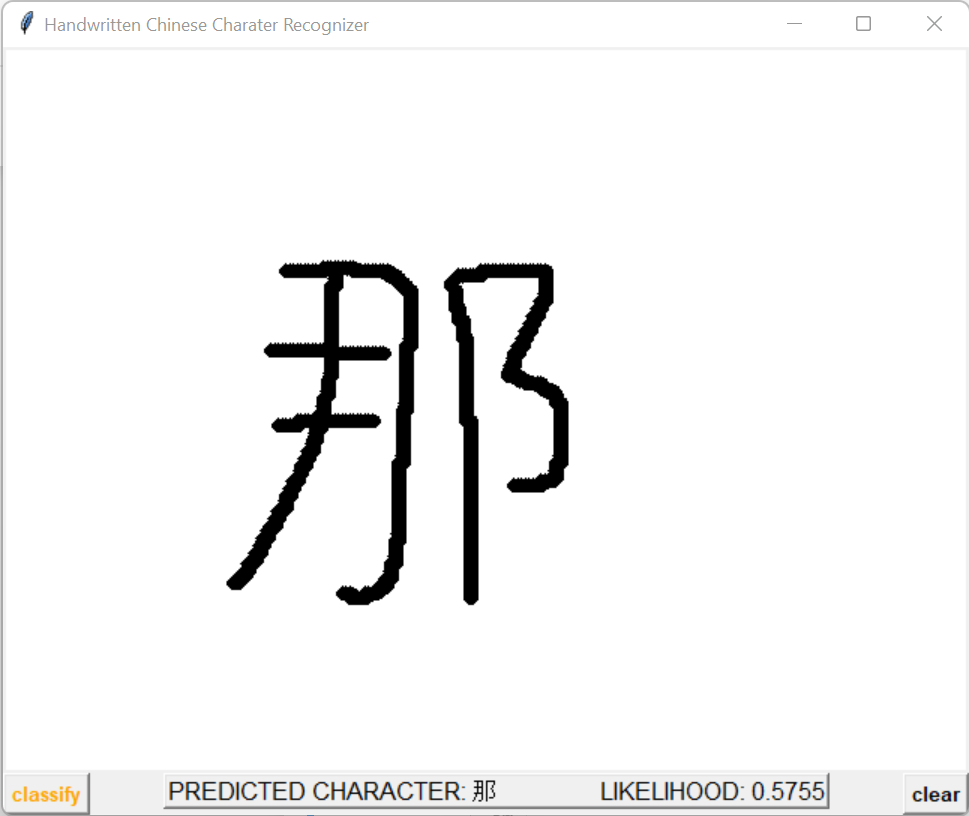

The above images are examples of how we can draw in our GUI and the utilize our PyTorch CNN model to predict the drawn character as well as get the likelihood for those characters.

# Conclusion: Insights and Follow-ups

## Successes and Next Steps

We were successful in creating the baby steps towards our original goal: creating a neural network that could use live video feed to read handwritten Chinese text. The next natural steps, given that our convolutional neural network only has this success with 190 different characters, is to incrementally size-up the network to handle more classes while maintaining an acceptable accuracy. --
It is worth noting that for 190 characters, an 83% accuracy is more or less acceptable given that Chinese has thousands of commonly used characters. However, if we were to implement a network to classify even just one thousand characters, we would require an accuracy of at least 90% as a lack of integrity could mean losing potential consumers of the product.

After successfully sizing up the network to handle nearly all classes, the next step would be to create a recurrent neural network that could handle a stream of characters and properly recognize that stream, for example, "你好" ("hello"). Once being able to recognize a stream of characters statically (first, two characters at a time, then any arbitrary number of characters), learning to implement this with computer vision such as the YOLO methodology would be close to the final goal.

The final goal would be retrieving information that is recognized so that it could be implemented in something such as a translation app, such as how Google translate allows users with the mobile application to hover above foreign text and retreive real-time translations.

## Methods Taken, and Acknowledgments

### Production Sprints

Our team formed around April 15th, which was the middle of week 3 of Spring quarter 2022. We spent about a week deciding on a project that we could do. I (Aleksa) initially proposed computer vision for text recogntion in English, and then extended it to Chinese. Partners Taylor and Alec suggested ideas such as the taking a picture of text and recognizing words and/or characters from there, and also the GUI drawing-recognizing which we ultimately implemented. During this week, we searched for a dataset that met our needs such that we could proceed with our idea. By the end of week 4, we submitted our team and project idea, and by the beginning of week 5 we submitted our project proposal and initial progress report.

Keeping in mind that we had limited time and resources to work on this project, we set deadlines for stages of the project, i.e. finishing gathering and cleaning data by the end of week 6, and actively working on model building and GUI implementation during week 7. The overall goal was to be finished with the project by week 8 in order to allow for wiggle room for debugging and feature improvements before presenting in week 9, which we have successfully accomplished. 

### Model Building and GUI Implementation

When we originally tried to implement the feed-forward neural network, we tried to use all 6880 classes with the entire valid dataset of images. However, we found that training just the FFNN alone would take over 72 hours. So, we decided to use a subset of classes, specifically 190 classes. However, even this amount was too much for the FFNN, but this time in terms of accuracy. The accuracy for the FFNN when using 190 classes remained at less than 1% even after 50 or 100 epochs of training. So, we used just 10 classes to train the FFNN. As this proved to provide okay accuracy of around 50% to 60%, we bumped up the number of classes to 25. After playing around with the layering of the FFNN in terms of the number of layers, the size of the layers, and the inclusion of a Dropout layer, this FFNN model defined in this code was deemed the most optimal for the sake of starting off our project. The loss, however, would skyrocket at seemingly-random epochs and the accuracy would plummet as well. As such, we adjusted the learning rate from 0.001 (1x10^-3) to 0.0005 (5x10^-4), and this stabilized the loss. 

As for the convolutional neural network, the original structure we used implemented 4 layers (each with a convolution and max pooling), and no Dropout layer. The accuracy for this, using 190 classes, sat at around 80% with a loss at around 1.0. Soon, we added a 5th layer following the same structure and now including a Dropout layer and the accuracy bumped up to 84% with a loss at around 0.8. This CNN structure is in the code above where the model is defined.

The largest roadblock in implementing the GUI was in making it properly capture the drawing. Taylor and Alec mostly collaborated on creating a working GUI that could take in a user's drawing, and that provides buttons for clearing the drawing, and saving the drawing to be forwarded to the prediction model. 

Overall, we could've implemented more models side by side and compared them all towards the end, but with our dataset being around 20 gigabytes, plus our limited computing resources (or money for such), we had to work with the time available across team members. As such, we are still proud of our accomplishments thus far and are excited to learn more moving forward.